In [5]:
# default_exp moving_average

# Moving Averages

> Code for Simple Moving Average and Weighted Moving Average.

In [6]:
#hide
from nbdev.showdoc import *

In [7]:
#export
import numpy as np
from numba import jit
import pandas as pd

## Random Time Series

> Generate Random Time Series
> Include Seasonality, Trend, Level and Noise

In [73]:
#export
def random_time_series(
    num_points=30,
    level=3,
    trend_amplitude=1 / 3,
    sinus_amplitude=1,
    noise_amplitude=2 / 1,
    start=0,
    finish=4 * np.pi,
):

    interval = np.linspace(
        start,
        finish,
        num=num_points + 1,
    )

    season = np.sin(interval[:-1])
    trend = np.vectorize(lambda x: trend_amplitude * x)(interval[:-1])
    noise = noise_amplitude * np.random.random((num_points,))
    signal = level + season + trend + noise
    return interval, signal

## Simple Moving Average

In [74]:
#export
@jit(nopython=True)
def simple(
    ts,
    n=1,
):

    l = len(ts)
    if n > l:
        raise Exception('n should be less than the length of the time-series')

    f = np.zeros((l + 1,))
    f[:n] = np.full(n, np.nan)

    for i in range(l - n + 1):
        f[n + i] = np.mean(ts[i:n + i])
    return f

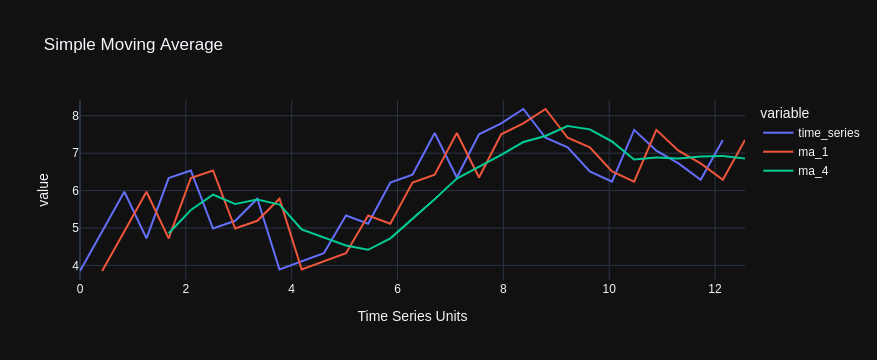

In [75]:
interval, d = random_time_series()
n1, n2 = 1, 4
df = pd.DataFrame(
    {
        'time_series': np.append(d, np.nan),
        f'ma_{n1}': simple(ts=d, n=n1),
        f'ma_{n2}': simple(ts=d, n=n2),
    },
    index=interval,
)
df.index = interval
df.index.name = 'Time Series Units'

fig = df.plot(
    backend='plotly',
    title=f'Simple Moving Average',
)

fig.update_layout(template="plotly_dark",)

## Weighted Moving Average

In [48]:
#export
@jit(nopython=True)
def weighted(
    ts,
    ws,
):

    l = len(ts)
    n = len(ws)
    w = np.sum(ws)

    if n > l:
        raise Exception('The length of ws should be less than the length of ts')

    f = np.zeros((l + 1,))
    f[:n] = np.full(n, np.nan)

    for i in range(l - n + 1):
        f[n + i] = (1 / w) * np.dot(ws, ts[i:n + i])
    return f

<AxesSubplot:>

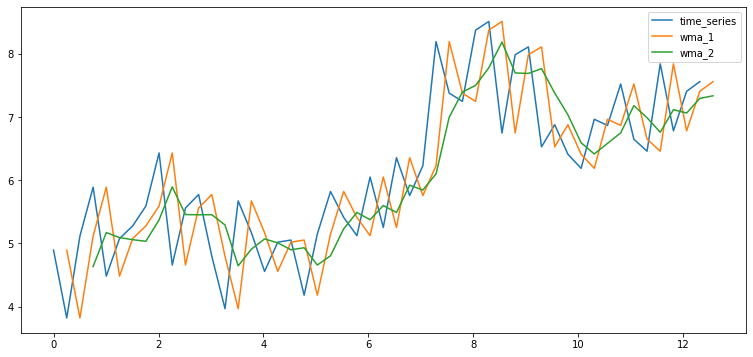

In [49]:
num_points = 50
interval = np.linspace(
    0,
    4 * np.pi,
    num=num_points + 1,
)

level = 3
season = np.sin(interval[:-1])
trend = np.vectorize(lambda x: (1 / 3) * x)(interval[:-1])
noise = (2 / 1) * np.random.random((num_points,))
d = level + season + trend + noise

df = pd.DataFrame(
    {
        'time_series':
            np.append(d, np.nan),
        f'wma_{1}':
            weighted(
                ts=d,
                ws=np.array([1], dtype=float),
            ),
        f'wma_{2}':
            weighted(
                ts=d,
                ws=np.array([1, 1.5, 2], dtype=float),
            ),
    },
    index=interval,
)
df.index = interval

df.plot(figsize=(13, 6))

## Dataframes and Figures

> Generates a Time Series Dataframe and a Figure Object

> The Values of The Time  Series are Simulated

> Includes Forecasting with Moving Averages 

In [66]:
#export
def SMA(*args):
    """
    Creates a Dataframe with simulated data and forescasts
    with a set of Simple Moving Averages
    
    -----
    Parameters
    -----
    
    args: list of integers. Each value represent a Moving 
          Average Forecast and its corresponding
          window size
          
    -------
    Returns
    -------
    tuple: First element is the Pandas Dataframe and the second
           is ploty's fig object
    """

    if len(args) == 0:
        raise Exception("list in *args should include at least one value")

        

    interval, d = random_time_series()

    preds = {f'ma_{n}': simple(ts=d, n=n) for n in args}
    ts = {'time_series': np.append(d, np.nan)}
    ts.update(preds)
    df = pd.DataFrame(
       ts,
        index=interval,
    )
    df.index = interval
    df.index.name = 'Time Series Units'

    fig = df.plot(
        backend='plotly',
        title=f'Simple Moving Average',
    )

    fig.update_layout(template="plotly_dark",)

    return df, fig

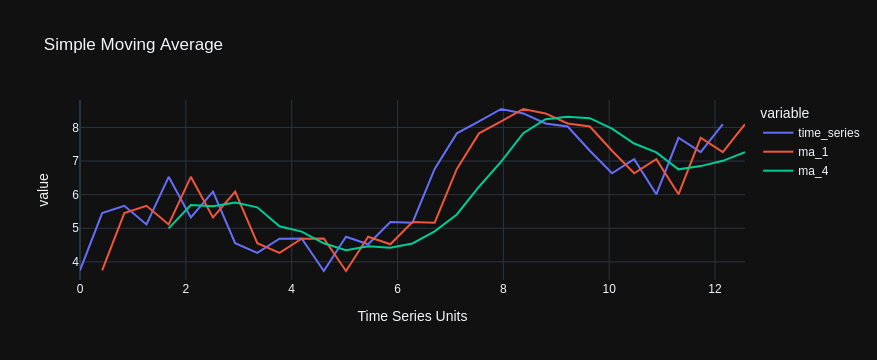

In [67]:
_,fig = SMA(1,4)
fig.show()

In [71]:
#export
def WMA(*args):
    """
    Creates a Dataframe with simulated data and forescasts
    with a set of Simple Moving Averages
    
    -----
    Parameters
    -----
    
    args: list of lists. Each list represents a set
          of Weights for the WMA
          
    -------
    Returns
    -------
    tuple: First element is the Pandas Dataframe and the second
           is ploty's fig object
    """

    if len(args) == 0:
        raise Exception("list in *args should include at least one value")

    interval, d = random_time_series()

    preds = {
        f'wma_{ws}': weighted(
            ts=d,
            ws=np.array(ws, dtype=float),
        ) for ws in args
    }
    ts = {'time_series': np.append(d, np.nan)}
    ts.update(preds)
    df = pd.DataFrame(
        ts,
        index=interval,
    )
    df.index = interval
    df.index.name = 'Time Series Units'

    fig = df.plot(
        backend='plotly',
        title=f'Weighted Moving Average',
    )

    fig.update_layout(template="plotly_dark",)
    
    return df, fig

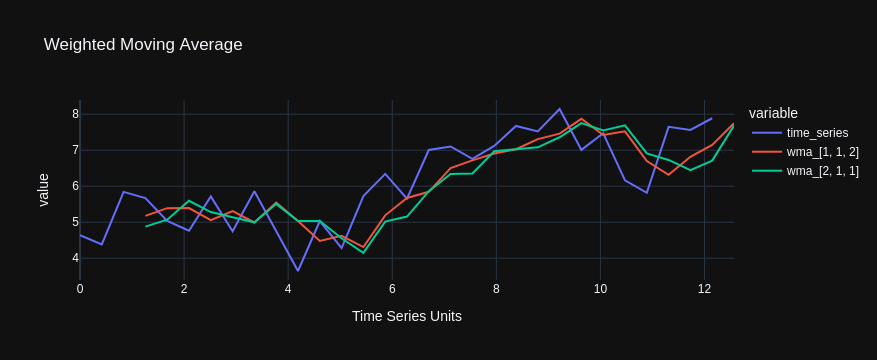

In [72]:
_,fig = WMA([1,1,2],[2,1,1])
fig.show()

## Sum of Two MAs is a WMA

<AxesSubplot:>

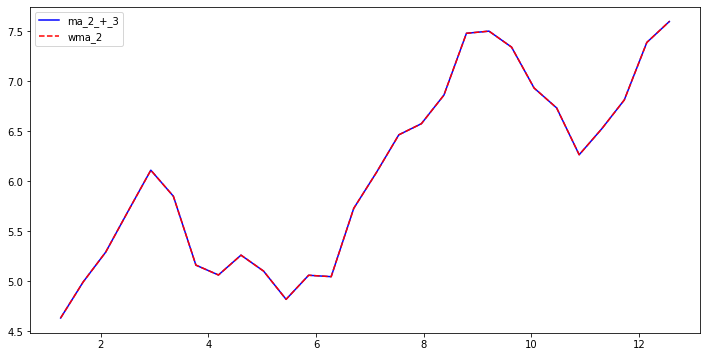

In [7]:
num_points = 30
interval = np.linspace(
    0,
    4 * np.pi,
    num=num_points + 1,
)

level = 3
season = np.sin(interval[:-1])
trend = np.vectorize(lambda x: (1 / 3) * x)(interval[:-1])
noise = (2 / 1) * np.random.random((num_points,))
d = level + season + trend + noise

n1, n2 = 2, 3

weights = np.array(
    [1 / (3 * 2), 1 / (2 * 2) + 1 / (3 * 2), 1 / (2 * 2) + 1 / (3 * 2)],
    dtype=float,
)

df = pd.DataFrame(
    {
        f'ma_{n1}_+_{n2}':
            (1 / 2) * (simple(ts=d, n=n1) + simple(ts=d, n=n2)),
        f'wma_{2}':
            weighted(
                ts=d,
                ws=weights,
            ),
    },
    index=interval,
)
df.index = interval

df.plot(figsize=(12, 6), style=[
    'b-',
    'r--',
])